In [70]:
#IMPORTS

import numpy as np
import matplotlib.pyplot as plt
import pygame
import random
import pandas as pd

from pygame.locals import (
    RLEACCEL,
    K_UP,
    K_DOWN,
    K_LEFT,
    K_RIGHT,
    K_ESCAPE,
    KEYDOWN,
    QUIT,
)

In [51]:
#CLASS DEFINITIONS

class Drone(pygame.sprite.Sprite):
    def __init__(self, ID, xi, yi, zi, mode):
        self.x = xi
        self.y = yi
        self.z = zi
        self.ID = ID
        self.mode = mode
        super(Drone, self).__init__()
        self.surf = pygame.Surface((10, 10))
        self.surf.fill((0, 191, 255))
        self.rect = self.surf.get_rect(
            center=(xi,yi,)
        )

        self.direction = np.pi / 2
        #self.direction = random.randint(0,43) / 7
        self.force = 10

        self.l = self.rect.left
        self.t = self.rect.top
        self.prevl = self.l
        self.prevt = self.t

    def update(self,SCREEN_WIDTH, SCREEN_HEIGHT):

        self.prevl = self.l
        self.prevt = self.t


        if self.mode==0:
            self.direction=0
            self.force=0
        elif self.mode==1:
            self.direction = random.randint(0,8)
            self.force = 10
        elif self.mode==2:
            self.direction = 0
            self.force = 10

        if self.force > 0:
            angle = self.direction*np.pi/4
            dx = round(self.force * np.cos(self.direction))
            dy = -1*round(self.force * np.sin(self.direction))
            self.rect.move_ip(dx,dy)

        if self.rect.left < 0:
            self.rect.left = 0
        if self.rect.right > SCREEN_WIDTH:
            self.rect.right = SCREEN_WIDTH
        if self.rect.top <= 0:
            self.rect.top = 0
        if self.rect.bottom >= SCREEN_HEIGHT:
            self.rect.bottom = SCREEN_HEIGHT

        self.l = self.rect.left
        self.t = self.rect.top

class Drone_NSEW(pygame.sprite.Sprite):
    def __init__(self, ID, xi, yi, zi, col):
        self.x = xi
        self.y = yi
        self.z = zi
        self.ID = ID
        super(Drone_NSEW, self).__init__()
        self.surf = pygame.Surface((10, 10))
        if col == 0:
            self.surf.fill((0, 191, 255))
        elif col == 1:
            self.surf.fill((255,95,31))
        elif col == 2:
            self.surf.fill((159,43,104))
        self.rect = self.surf.get_rect(
            center=(xi,yi,)
        )

        self.move = 'r'
        #self.direction = random.randint(0,43) / 7
        self.force = 1

        self.l = self.rect.left
        self.t = self.rect.top
        self.prevl = self.l
        self.prevt = self.t

    def update(self,SCREEN_WIDTH, SCREEN_HEIGHT):

        self.prevl = self.l
        self.prevt = self.t

        if self.force > 0:
            if self.move == 'r':
                self.rect.move_ip(self.force,0)
            elif self.move =='u':
                self.rect.move_ip(0,-1*self.force)
            elif self.move == 'l':
                self.rect.move_ip(-1*self.force,0)
            elif self.move == 'd':
                self.rect.move_ip(0,self.force)

        if self.rect.left < 0:
            self.rect.left = 0
        if self.rect.right > SCREEN_WIDTH:
            self.rect.right = SCREEN_WIDTH
        if self.rect.top <= 0:
            self.rect.top = 0
        if self.rect.bottom >= SCREEN_HEIGHT:
            self.rect.bottom = SCREEN_HEIGHT

        self.l = self.rect.left
        self.t = self.rect.top

class Goal(pygame.sprite.Sprite):
    def __init__(self, x, y, z):
        super(Goal, self).__init__()
        self.surf = pygame.Surface((10, 10))
        self.surf.fill((57,255,20))
        self.rect = self.surf.get_rect(
            center=(x,y,)
        )

class Obstacle(pygame.sprite.Sprite):
    def __init__(self,x,y,z,xdim,ydim,zdim):
        super(Obstacle, self).__init__()
        self.surf = pygame.Surface((xdim,ydim))
        self.surf.fill((255,0,0))
        self.rect = self.surf.get_rect(
            center=(x,y,)
        )

class Scanner(pygame.sprite.Sprite):
    def __init__(self,left,top,xdim,ydim,dir):
        super(Scanner, self).__init__()
        self.surf = pygame.Surface((xdim,ydim))
        self.surf.fill((255,255,255))
        self.rect = self.surf.get_rect()
        self.rect.left = left
        self.rect.top = top
        self.dir = dir

    def update(self):
        if self.dir == "r":
            self.rect.move_ip(1,0)
        elif self.dir == "l":
            self.rect.move_ip(-1,0)
        elif self.dir == "u":
            self.rect.move_ip(0,-1)
        elif self.dir == "d":
            self.rect.move_ip(0,1)
        elif self.dir == "ur":
            self.rect.move_ip(1,-1)
        elif self.dir == "ul":
            self.rect.move_ip(-1,-1)
        elif self.dir == "dl":
            self.rect.move_ip(-1,1)
        elif self.dir == "dr":
            self.rect.move_ip(1,1)

In [3]:
#OBSERVE() DEFINITION

def observe(entity,spritesgroup,dist,scansgroup,ogroup,ggroup,dgroup):
    l=entity.rect.left
    lx=l-1
    r=entity.rect.right
    t=entity.rect.top
    tx=t-1
    b=entity.rect.bottom

    txx = t-10
    lxx = l-10


    results = np.array([[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0],[0,0]])

    rscan = Scanner(r,t,1,10,"r")
    uscan = Scanner(l,tx,10,1,"u")
    lscan = Scanner(lx,t,1,10,"l")
    dscan = Scanner(l,b,10,1,"d")
    urscan = Scanner(r,txx,10,10,"ur")
    ulscan = Scanner(lxx,txx,10,10,"ul")
    dlscan = Scanner(lxx,b,10,10,"dl")
    drscan = Scanner(r,b,10,10,"dr")
    scansgroup.add(rscan,uscan,lscan,dscan,urscan,ulscan,dlscan,drscan)

    for i in range(dist):
        if pygame.sprite.spritecollideany(rscan,spritesgroup):
            if pygame.sprite.spritecollideany(rscan,ogroup):
                results[0] = [1,i]
            elif pygame.sprite.spritecollideany(rscan,ggroup):
                results[0] = [2,i]
            elif pygame.sprite.spritecollideany(rscan,dgroup):
                results[0] = [3,i]
            break
        rscan.update()

    for i in range(dist):
        if pygame.sprite.spritecollideany(uscan,spritesgroup):
            if pygame.sprite.spritecollideany(uscan,ogroup):
                results[1] = [1,i]
            elif pygame.sprite.spritecollideany(uscan,ggroup):
                results[1] = [2,i]
            elif pygame.sprite.spritecollideany(uscan,dgroup):
                results[1] = [3,i]
            break
        uscan.update()

    for i in range(dist):
        if pygame.sprite.spritecollideany(lscan,spritesgroup):
            if pygame.sprite.spritecollideany(lscan,ogroup):
                results[2] = [1,i]
            elif pygame.sprite.spritecollideany(lscan,ggroup):
                results[2] = [2,i]
            elif pygame.sprite.spritecollideany(lscan,dgroup):
                results[2] = [3,i]
            break
        lscan.update()

    for i in range(dist):
        if pygame.sprite.spritecollideany(dscan,spritesgroup):
            if pygame.sprite.spritecollideany(dscan,ogroup):
                results[3] = [1,i]
            elif pygame.sprite.spritecollideany(dscan,ggroup):
                results[3] = [2,i]
            elif pygame.sprite.spritecollideany(dscan,dgroup):
                results[3] = [3,i]
            break
        dscan.update()

    for i in range(dist):
        if pygame.sprite.spritecollideany(urscan,spritesgroup):
            if pygame.sprite.spritecollideany(urscan,ogroup):
                results[4] = [1,i+19]
            elif pygame.sprite.spritecollideany(urscan,ggroup):
                results[4] = [2,i+19]
            elif pygame.sprite.spritecollideany(urscan,dgroup):
                results[4] = [3,i+19]
            break
        urscan.update()

    for i in range(dist):
        if pygame.sprite.spritecollideany(ulscan,spritesgroup):
            if pygame.sprite.spritecollideany(ulscan,ogroup):
                results[5] = [1,i+19]
            elif pygame.sprite.spritecollideany(ulscan,ggroup):
                results[5] = [2,i+19]
            elif pygame.sprite.spritecollideany(ulscan,dgroup):
                results[5] = [3,i+19]
            break
        ulscan.update()

    for i in range(dist):
        if pygame.sprite.spritecollideany(dlscan,spritesgroup):
            if pygame.sprite.spritecollideany(dlscan,ogroup):
                results[6] = [1,i+19]
            elif pygame.sprite.spritecollideany(dlscan,ggroup):
                results[6] = [2,i+19]
            elif pygame.sprite.spritecollideany(dlscan,dgroup):
                results[6] = [3,i+19]
            break
        dlscan.update()

    for i in range(dist):
        if pygame.sprite.spritecollideany(drscan,spritesgroup):
            if pygame.sprite.spritecollideany(drscan,ogroup):
                results[7] = [1,i+19]
            elif pygame.sprite.spritecollideany(drscan,ggroup):
                results[7] = [2,i+19]
            elif pygame.sprite.spritecollideany(drscan,dgroup):
                results[7] = [3,i+19]
            break
        drscan.update()


    for entity in scansgroup:
        entity.kill()

    return results

In [4]:
# Calculates the Manhattan distance of each drone from the goal - this is the heuristic for our A* algorithm
def potential(state,goal_l,goal_t):
    p = 0
    for drone in state:
        p += abs(drone[0]-goal_l)
        p += abs(drone[1]-goal_t)
    return p

In [40]:
def goodformation(dronepos):
    penalty = 0
    for i in range(len(dronepos)):
        for j in range(i+1,len(dronepos)):
            dist = abs(dronepos[i][0]-dronepos[j][0]) + abs(dronepos[i][1]-dronepos[j][1])
            if dist >= 50:
                penalty += dist
            elif dist <= 20:
                penalty += 500/(dist+1)

    return penalty

def goodformation2(dronepos):
    penalty = 0
    for i in range(len(dronepos)):
        for j in range(i+1,len(dronepos)):
            dist = abs(dronepos[i][0]-dronepos[j][0]) + abs(dronepos[i][1]-dronepos[j][1])
            if dist >= 35:
                penalty += dist
            elif dist <= 20:
                penalty += 500/(dist+1)

    return penalty

def goodformation3(dronepos):
    penalty = 0
    for i in range(len(dronepos)):
        for j in range(i+1,len(dronepos)):
            ydiff=abs(dronepos[i][1]-dronepos[j][1])
            if ydiff >= 5:
                penalty += ydiff
            
            dist = abs(dronepos[i][0]-dronepos[j][0]) + abs(dronepos[i][1]-dronepos[j][1])
            if dist <= 20:
                penalty += 500/(dist+1)

    return penalty

def goodformation4(dronepos):
    penalty = 0
    for i in range(len(dronepos)):
        for j in range(i+1,len(dronepos)):
            xdiff=abs(dronepos[i][0]-dronepos[j][0])
            if xdiff >= 5:
                penalty += xdiff
            
            dist = abs(dronepos[i][0]-dronepos[j][0]) + abs(dronepos[i][1]-dronepos[j][1])
            if dist <= 30:
                penalty += 500/(dist+1)

    return penalty

In [93]:
# provide whatmove with two consecutive states to determine what move was made
def whatmove(states,start,end):
    initial = states[start]
    final = states[end]
    results = []
    
    for i in range(len(initial)):
        xi = initial[i][0]
        yi = initial[i][1]
        xf = final[i][0]
        yf = final[i][1]
        xdiff = xf-xi
        ydiff = yf-yi
        if xdiff > 0 and ydiff == 0:
            results.append('r')
        elif xdiff < 0 and ydiff == 0:
            results.append('l')
        elif xdiff == 0  and ydiff > 0:
            results.append('d')
        elif xdiff == 0  and ydiff < 0:
            results.append('u')

    return results


In [154]:
pygame.init()

clock = pygame.time.Clock()

#Sets the height and width of the environment
SCREEN_WIDTH = 600
SCREEN_HEIGHT = 600

screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))


allsprites = pygame.sprite.Group()

d1 = Drone_NSEW(1,np.random.randint(10,40),np.random.randint(265,295),0,0)
d2 = Drone_NSEW(1,np.random.randint(10,40),np.random.randint(305,335),0,1)
d3 = Drone_NSEW(1,np.random.randint(50,80),np.random.randint(285,315),0,2)

#d1 = Drone_NSEW(1,75,275,0)
#d2 = Drone_NSEW(1,75,300,0)
#d3 = Drone_NSEW(1,75,325,0)

dinits = [[d1.rect.left,d1.rect.top],[d2.rect.left,d2.rect.top],[d3.rect.left,d3.rect.top]]

drones = pygame.sprite.Group()
drones.add(d1,d2,d3)
allsprites.add(d1,d2,d3)

for entity in drones:
    entity.force = 10

dronelist = [d1,d2,d3]

ygoal = np.random.randint(150,450)
endgoal = Goal(550,ygoal,0)

goals = pygame.sprite.Group()
goals.add(endgoal)
allsprites.add(endgoal)

goal_l = endgoal.rect.left
goal_t = endgoal.rect.top


obstacles = pygame.sprite.Group()
oinits = []

for i in range(40):
    y = np.random.randint(50,550)
    x = np.random.randint(150,450)
    ydim = np.random.randint(10,25)
    xdim = np.random.randint(10,25)
    obs = Obstacle(x,y,0,xdim,ydim,0)
    obstacles.add(obs)
    allsprites.add(obs)
    oinits.append([obs.rect.left,obs.rect.top])



running = True

states = {}
sources = {}

states[0] = dinits
sources[0] = -1

currentstate = dinits
currentdist = 0
currentID = 0


currentpotential = potential(dinits,goal_l,goal_t)
priorityqueue = [0]
distlist = [0]
potlist = [currentpotential]
astarlist = [currentpotential]

donequeue = []
donedistlist = []
donepotlist = []
doneastarlist = []

counter = 1

#screen.fill((0,0,0))
#for entity in allsprites:
#    screen.blit(entity.surf, entity.rect)
#pygame.display.flip()
#pygame.time.wait(10000)

while running:
    # Can force exit the simulation using ESC or by closing the window
    for event in pygame.event.get():
        if event.type == KEYDOWN:
            if event.key == K_ESCAPE:
                running = False

        elif event.type == QUIT:
            running = False

    

    commands = [0,0,0]

    # I gotta find a better way to do this
    for a in ['u','d','r','l']:
        commands[0] = a
        for b in ['u','d','r','l']:
            commands[1] = b
            for c in ['u','d','r','l']:
                commands[2] = c


                for i in range(len(dronelist)):
                    entity = dronelist[i]
                    entity.rect.left = currentstate[i][0]
                    entity.rect.top = currentstate[i][1]
            
                for i in range(len(dronelist)):
                    entity = dronelist[i]
                    entity.move = commands[i]
                    entity.update(SCREEN_WIDTH, SCREEN_HEIGHT)
                            
                crash = 0
                for entity in drones:
                    if pygame.sprite.spritecollideany(entity,obstacles):
                        crash = 1
                    else:
                        for entity2 in drones:
                            if entity != entity2 and pygame.sprite.collide_rect(entity, entity2):
                                crash = 1
                            
                        

                dronepos = [[d1.rect.left,d1.rect.top],[d2.rect.left,d2.rect.top],[d3.rect.left,d3.rect.top]]

                penalty = goodformation4(dronepos)

                if crash == 0 and dronepos in states.values():
                    ID = [k for k, v in states.items() if v == dronepos]
                    if len(ID) > 1:
                        print('You are about to encounter some never before seen errors')
                    ID = ID[0]
                    if ID in priorityqueue and ID in donequeue:
                        print('Not good')


                    elif ID in priorityqueue:
                        pos = priorityqueue.index(ID)
                        newdist = currentdist + 10 + penalty
                        if newdist < distlist[pos]:
                            x = priorityqueue.pop(pos)
                            y = distlist.pop(pos)
                            y = currentdist + 10 + penalty
                            z = potlist.pop(pos)
                            w = astarlist.pop(pos)
                            w = y + z

                            sources[ID] = currentID

                            if w >= astarlist[-1]:
                                priorityqueue.append(x)
                                distlist.append(y)
                                potlist.append(z)
                                astarlist.append(w)
                            else:
                                for i in range(1,len(astarlist)):
                                    if w <= astarlist[i]:
                                        index=i
                                        priorityqueue.insert(index,x)
                                        distlist.insert(index,y)
                                        potlist.insert(index,z)
                                        astarlist.insert(index,w)
                                        break



                    elif ID in donequeue:
                        pos = donequeue.index(ID)
                        newdist = currentdist + 10 + penalty
                        if newdist < donedistlist[pos]:
                            x = donequeue.pop(pos)
                            y = donedistlist.pop(pos)
                            y = currentdist + 10 + penalty
                            z = donepotlist.pop(pos)
                            w = doneastarlist.pop(pos)
                            w = y + z

                            sources[ID] = currentID

                            if w >= astarlist[-1]:
                                priorityqueue.append(x)
                                distlist.append(y)
                                potlist.append(z)
                                astarlist.append(w)
                            else:
                                for i in range(1,len(astarlist)):
                                    if w <= astarlist[i]:
                                        index=i
                                        priorityqueue.insert(index,x)
                                        distlist.insert(index,y)
                                        potlist.insert(index,z)
                                        astarlist.insert(index,w)
                                        break


                    else:
                        print('Not good')
            

                if crash == 0 and dronepos not in states.values():
                    states[counter] = dronepos
                    sources[counter] = currentID
                    dist = currentdist + 10 + penalty
                    pot = potential(dronepos,goal_l,goal_t)
                    astar = dist+pot
                    if astar >= astarlist[-1]:
                        priorityqueue.append(counter)
                        distlist.append(dist)
                        potlist.append(pot)
                        astarlist.append(astar)
                    else:
                        for i in range(1,len(astarlist)):
                            if astar <= astarlist[i]:
                                index=i
                                priorityqueue.insert(index,counter)
                                distlist.insert(index,dist)
                                potlist.insert(index,pot)
                                astarlist.insert(index,astar)
                                break

                    counter += 1

                for i in range(len(dronelist)):
                    entity = dronelist[i]
                    entity.rect.left = currentstate[i][0]
                    entity.rect.top = currentstate[i][1]


    screen.fill((0,0,0))
    for entity in allsprites:
        screen.blit(entity.surf, entity.rect)  
    pygame.display.flip()

    x = priorityqueue.pop(0)
    y = distlist.pop(0)
    z = potlist.pop(0)
    w = astarlist.pop(0)

    donequeue.append(x)
    donedistlist.append(y)
    donepotlist.append(z)
    doneastarlist.append(w)

    currentID = priorityqueue[0]
    currentstate = states[currentID]
    currentdist = distlist[0]
    currentpotential = potlist[0]

    if currentpotential <= 150:
        running=False

    #if counter >= 100000:
    #    running=False

pygame.quit()
    
#print(dinits)
#print(goal_l,goal_t)
#print(oinits)
#print(len(priorityqueue))
#print(donequeue)

In [155]:
shortestpath = []
nowstate = priorityqueue[0]
shortestpath.append(nowstate)
while True:
    prevstate = sources[nowstate]
    if prevstate == -1:
        break
    else:
        nowstate = prevstate
        shortestpath.append(nowstate)

print(shortestpath)

[7212, 7149, 7086, 7023, 6960, 6897, 6834, 6771, 6713, 6678, 6643, 6613, 6182, 4885, 4849, 4801, 4746, 4647, 4537, 4491, 4454, 4420, 4400, 3384, 3406, 3202, 3139, 3076, 3017, 2954, 2891, 2844, 2775, 2740, 2706, 2684, 2210, 2153, 2120, 2077, 2047, 1490, 1461, 1326, 1203, 1111, 1014, 955, 892, 861, 798, 735, 672, 610, 548, 369, 313, 225, 101, 38, 0]


In [156]:
if shortestpath[0] != 0:
    shortestpath.reverse()
print(shortestpath)

[0, 38, 101, 225, 313, 369, 548, 610, 672, 735, 798, 861, 892, 955, 1014, 1111, 1203, 1326, 1461, 1490, 2047, 2077, 2120, 2153, 2210, 2684, 2706, 2740, 2775, 2844, 2891, 2954, 3017, 3076, 3139, 3202, 3406, 3384, 4400, 4420, 4454, 4491, 4537, 4647, 4746, 4801, 4849, 4885, 6182, 6613, 6643, 6678, 6713, 6771, 6834, 6897, 6960, 7023, 7086, 7149, 7212]


In [157]:
moveslist = []
for i in range(len(shortestpath)-1):
    move = whatmove(states,shortestpath[i], shortestpath[i+1])
    moveslist.append(move)
print(moveslist)

[['r', 'd', 'd'], ['r', 'r', 'l'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['u', 'r', 'r'], ['r', 'r', 'r'], ['r', 'd', 'r'], ['d', 'r', 'd'], ['d', 'd', 'd'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['r', 'd', 'r'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['d', 'd', 'd'], ['r', 'r', 'd'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['d', 'r', 'r'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['r', 'd', 'r'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['u', 'd', 'u'], ['r', 'r', 'u'], ['r', 'r', 'r'], ['u', 'r', 'r'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['d', 'u', 'd'], ['d', 'u', 'd'], ['r', 'r', 'r'], ['r', 'd', 'r'], ['r', 'r', 'r'], ['d', 'r', 'd'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['r', 'r', 'r'], ['r', 'r', 'r

In [158]:
pygame.init()

clock = pygame.time.Clock()

#Sets the height and width of the environment
SCREEN_WIDTH = 800
SCREEN_HEIGHT = 600

screen = pygame.display.set_mode((SCREEN_WIDTH, SCREEN_HEIGHT))

allsprites = pygame.sprite.Group()

d1 = Drone_NSEW(1,np.random.randint(50,100),300,0,0)
d2 = Drone_NSEW(2,np.random.randint(50,100),250,0,1)
d3 = Drone_NSEW(3,np.random.randint(50,100),350,0,2)

d1.rect.left = dinits[0][0]
d1.rect.top = dinits[0][1]
d2.rect.left = dinits[1][0]
d2.rect.top = dinits[1][1]
d3.rect.left = dinits[2][0]
d3.rect.top = dinits[2][1]

drones = pygame.sprite.Group()
drones.add(d1,d2,d3)
allsprites.add(d1,d2,d3)

dronelist = [d1,d2,d3]

ygoal = np.random.randint(150,450)
endgoal = Goal(750,ygoal,0)
endgoal.rect.left = goal_l
endgoal.rect.top = goal_t

goals = pygame.sprite.Group()
goals.add(endgoal)
allsprites.add(endgoal)


for entity in obstacles:
    allsprites.add(entity)


for i in range(len(shortestpath)-1):

    thisstate = shortestpath[i]
    dronepos = states[thisstate]
    thismove = moveslist[i]

    for j in range(len(dronelist)):
        entity = dronelist[j]
        entity.rect.left = dronepos[j][0]
        entity.rect.top = dronepos[j][1]

    screen.fill((0,0,0))

    for entity in allsprites:
        screen.blit(entity.surf, entity.rect)
    
    pygame.display.flip()

    filename = 'run2_screen' + str(i) + '_' + thismove[0] + thismove[1] + thismove[2] + '.png'

    pygame.image.save(screen, filename)

pygame.quit()

In [178]:
from PIL import Image
import os, sys

In [187]:
def trip_rotate(srcdir, srcfile, r1, r2, r3):
    srcpath = srcdir+srcfile
    
    im1 = Image.open(srcpath)
    im1 = im1.rotate(90)
    im1.save(srcfile[:-7]+r1+'.png')

    im2 = Image.open(srcpath)
    im2 = im2.rotate(180)
    im2.save(srcfile[:-7]+r2+'.png')

    im3 = Image.open(srcpath)
    im3 = im3.rotate(270)
    im3.save(srcfile[:-7]+r3+'.png')

In [216]:
#srcdir = 'run3/uuu/'
#for file in os.listdir(srcdir):
#    trip_rotate(srcdir, file, 'lll','ddd','rrr')

In [88]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

In [218]:
data_dir = "run3"

dataset = ImageFolder(data_dir, transform = transforms.Compose([
    transforms.Resize((600,600)), transforms.ToTensor()
]))

In [219]:
img, label = dataset[0]
print(img.shape, label)

torch.Size([3, 600, 600]) 0


In [220]:
print(dataset.classes)

['ddd', 'ddl', 'ddr', 'ddu', 'dld', 'dll', 'dlr', 'dlu', 'drd', 'drr', 'dud', 'dur', 'duu', 'ldd', 'ldl', 'lld', 'lll', 'llr', 'llu', 'lrd', 'lrl', 'lrr', 'lud', 'lul', 'lur', 'luu', 'rdd', 'rdl', 'rdr', 'rdu', 'rll', 'rlr', 'rlu', 'rrd', 'rrl', 'rrr', 'rru', 'rur', 'ruu', 'udd', 'udl', 'udu', 'ull', 'ulu', 'urd', 'url', 'urr', 'uru', 'uud', 'uul', 'uur', 'uuu']


In [221]:
def display_img(img,label):
    print(f"Label : {dataset.classes[label]}")
    plt.imshow(img.permute(1,2,0))

Label : ddd


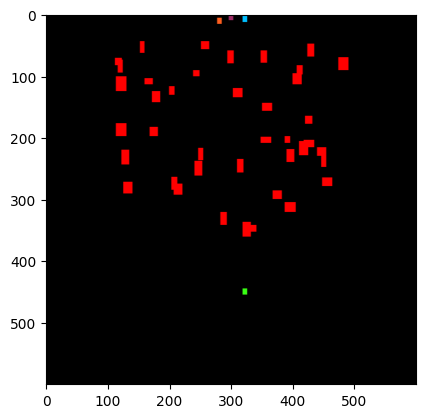

In [222]:
display_img(*dataset[0])

In [223]:
len(dataset)

2496

In [224]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [227]:
batch_size = 32
val_size = 500
train_size = len(dataset) - val_size

train_data, val_data = random_split(dataset,[train_size,val_size])
print(f"Length of Train Data : {len(train_data)}")
print(f"Length of Validation Data : {len(val_data)}")

Length of Train Data : 1996
Length of Validation Data : 500


In [228]:
train_dl = DataLoader(train_data, batch_size, shuffle=True, num_workers=4, pin_memory = True)
val_dl = DataLoader(val_data, batch_size*2, num_workers=4, pin_memory=True)

In [229]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig,ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images,nrow=8).permute(1,2,0))
        break

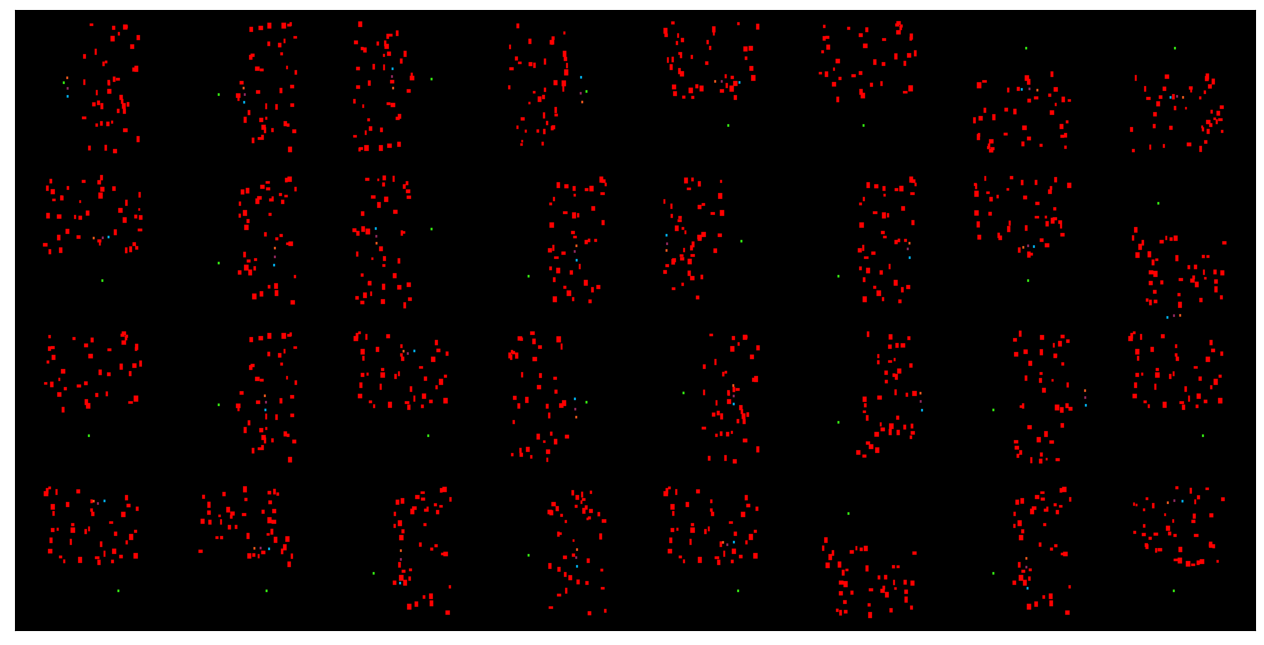

In [230]:
show_batch(train_dl)

In [231]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses =  [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [232]:
class UAVStateClassifier(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(

            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(64, 128, kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),

            nn.Flatten(),
            nn.Linear(82944,1024),
            nn.ReLU(),
            nn.Linear(1024,512),
            nn.ReLU(),
            nn.Linear(512,52)
        )

    def forward(self, xb):
        return self.network(xb)

In [233]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

  
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history

In [234]:
num_epochs = 30
opt_func = torch.optim.Adam
lr = 0.001#fitting the model on training data and record the result after each epoch
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

NameError: name 'model' is not defined